# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [30]:
## Similartly you can do preprocessing for review summary also.
#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
import re

words_to_keep = set(('not'))
stop -= words_to_keep

#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Summary'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [31]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedSummary']=final_string  
final['CleanedSummary']=final['CleanedSummary'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364171, 13)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...,love book miss hard cover version
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...,chicken soup rice month
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...,good swingi rhythm read aloud
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...,great way learn month


In [33]:
print(final['CleanedText'][0])
print("********")
print(final['CleanedSummary'][0])
print("*****")
final['CleanedText'][:]=final['CleanedText'][:]+' '+final['CleanedText'][:]+' '+final['CleanedSummary'][:]+' '+final['CleanedSummary'][:]
print(final['CleanedText'][0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
********
everi book educ
*****
witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg everi book educ everi book educ


In [34]:
final.shape

(364171, 13)

In [35]:
conn = sqlite3.connect('featureeng.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
conn.close()
    
with open('positive_words.pkl', 'wb') as f:
    pickle.dump(all_positive_words, f)
with open('negitive_words.pkl', 'wb') as f:
    pickle.dump(all_negative_words, f)

# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Note:

* preprocessing is done in previous assigments and stored in final.sqlite

In [2]:
con = sqlite3.connect('final.sqlite') 
final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [3]:
final.shape

(364171, 12)

In [4]:
from sklearn.model_selection import train_test_split
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

X = time_sorted_data['CleanedText'].values
Y = time_sorted_data['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, shuffle=False)

In [5]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(254919,) (254919,)
(109252,) (109252,)


# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [6]:
#BoW
count_vect = CountVectorizer(min_df = 50) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (254919, 6050)
the number of unique words : 6050



The optimal value of alpha is 1.00000000.


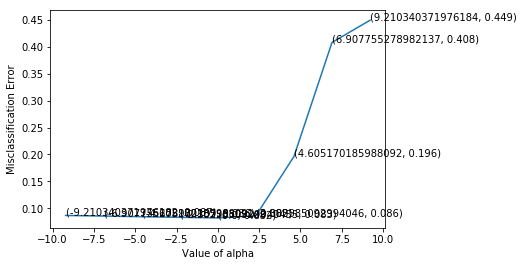

the misclassification error for each k value is :  [0.087 0.086 0.085 0.083 0.082 0.086 0.196 0.408 0.449]


Text(0,0.5,'score')

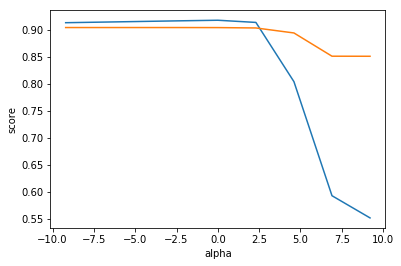

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Creating alpha values in the range from 10^-4 to 10^4
neighbors = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
# empty list that will hold cv scores
cv_scores = []
training_scores =[]
# perform 10-fold cross validation
for k in neighbors:
    nb = MultinomialNB(alpha=k)
    nb.fit(X_train_vec, Y_train)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(nb, X_test_vec, Y_test, cv=10, scoring='roc_auc')
    scores_training = nb.fit(X_train_vec, Y_train).score(X_train_vec, Y_train)
    cv_scores.append(scores.mean())
    training_scores.append(scores_training)
    #print((nb))
    
MSE = [1 - x for x in cv_scores]
#determining best k
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %.8f.' % optimal_alpha)

plt.plot(np.log(neighbors), MSE)

for xy in zip(np.log(neighbors), np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))
plt.plot(np.log(neighbors), cv_scores)
plt.plot(np.log(neighbors), training_scores)
plt.xlabel('alpha')
plt.ylabel('score')                                                        
# determining best value of alpha
#best_alpha = neighbors[cv_scores.index(max(cv_scores))]
#print('\nThe optimal value of alpha is %.3f.' % best_alpha) 

In [11]:
# ============================== Multinomial Naive Bayes with alpha = optimal_alpha ============================================
# instantiate learning model alpha = optimal_alpha
from sklearn.metrics import accuracy_score
mnb1 = MultinomialNB(alpha = optimal_alpha)

# fitting the model
mnb1.fit(X_train_vec, Y_train)

# predict the response
predictions= mnb1.predict(X_test_vec)
predictions1= mnb1.predict(X_train_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_mnb_alpha = optimal_alpha
bow_mnb_train_acc = max(cv_scores)*100
bow_mnb_test_acc = acc


The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 1.000 is 89.169992%


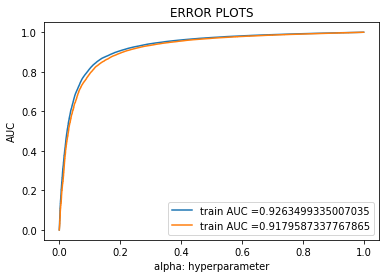

Train confusion matrix
[[ 27458  10571]
 [ 13907 202983]]
Test confusion matrix
[[13879  5202]
 [ 6630 83541]]


In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, mnb1.predict_proba(X_train_vec)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, mnb1.predict_proba(X_test_vec)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, mnb1.predict(X_train_vec)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, mnb1.predict(X_test_vec)))

### [5.1.1] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [13]:
# Please write all the code with proper documentation
# top 10  features
import operator
from nltk.probability import FreqDist, DictionaryProbDist, ELEProbDist, sum_logs
from nltk.classify.api import ClassifierI
from nltk.classify.naivebayes import NaiveBayesClassifier
nb = MultinomialNB(alpha=optimal_alpha).fit(X_train_vec, Y_train)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= count_vect.get_feature_names()    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])



Negative top 10 important features are:
('tast', -4.174592588303286)
('like', -4.255594226628023)
('product', -4.424308118931364)
('one', -4.698637689183009)
('flavor', -4.7400729276772715)
('tri', -4.849917472839326)
('would', -4.850507866311542)
('good', -5.007094086504942)
('coffe', -5.031362516749736)
('use', -5.0391770386804815)


### [5.1.2] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [14]:
# Please write all the code with proper documentation
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('like', -4.40894771917271)
('tast', -4.47930292964824)
('good', -4.614126623248737)
('flavor', -4.6357357369625625)
('love', -4.66429007687182)
('great', -4.684453739591529)
('use', -4.706008320452014)
('one', -4.762344073425835)
('product', -4.848698285348165)
('tea', -4.856661564089681)


# Accuracy on test data

In [15]:
# evaluate accuracy
#libraries
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

acc = accuracy_score(Y_test, predictions) * 100
print('\n Accuracy of the Multinomial naive Bayes of alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\n Precision of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\n Recall of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\n F1-Score of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))



 Accuracy of the Multinomial naive Bayes of alpha = 1.000 is 89.169992%

 Precision of the Multinomial naive Bayes of alpha = 1.000 is 0.941381

 Recall of the Multinomial naive Bayes of alpha = 1.000 is 0.926473

 F1-Score of the Multinomial naive Bayes of alpha = 1.000 is 0.933868


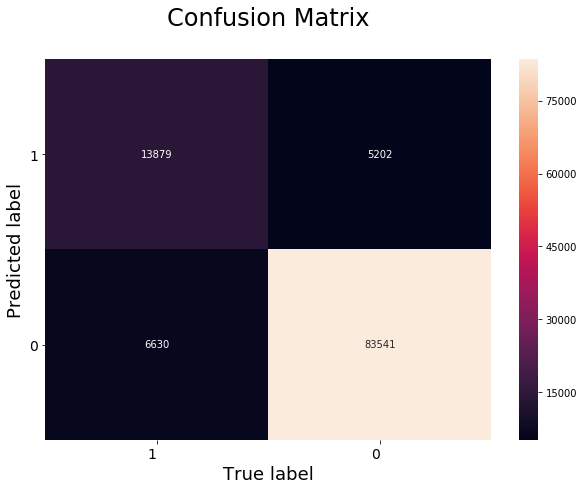

In [16]:
# Code for drawing seaborn heatmaps
#test confusion matrics
class_names = [1,0]
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Accuracy on train data set

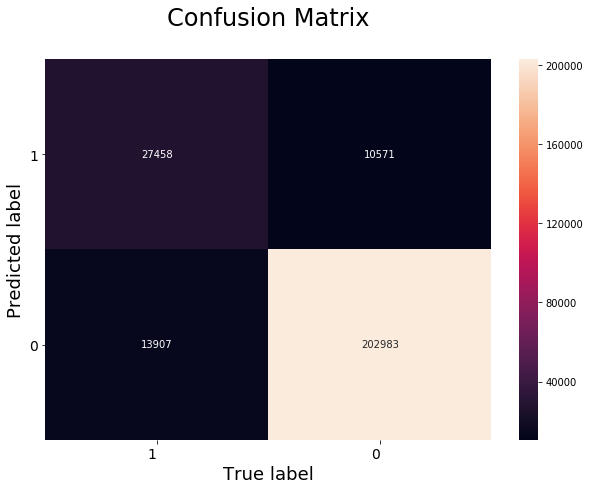

In [17]:
# Code for drawing seaborn heatmaps
#train confusion matrics
class_names = [1,0]
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, mnb1.predict(X_train_vec)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [18]:
# evaluate accuracy on train data set
acc = accuracy_score(Y_train,mnb1.predict(X_train_vec) ) * 100
print('\n Accuracy of the Multinomial naive Bayes of alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_train, mnb1.predict(X_train_vec), pos_label = 1) 
print('\n Precision of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_train, mnb1.predict(X_train_vec), pos_label = 1)
print('\n Recall of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_train, mnb1.predict(X_train_vec), pos_label = 1)
print('\n F1-Score of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))



 Accuracy of the Multinomial naive Bayes of alpha = 1.000 is 90.397734%

 Precision of the Multinomial naive Bayes of alpha = 1.000 is 0.950500

 Recall of the Multinomial naive Bayes of alpha = 1.000 is 0.935880

 F1-Score of the Multinomial naive Bayes of alpha = 1.000 is 0.943133


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [19]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(min_df=10)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (254919, 12671)
the number of unique words : 12671



The optimal value of alpha is 0.10000000.


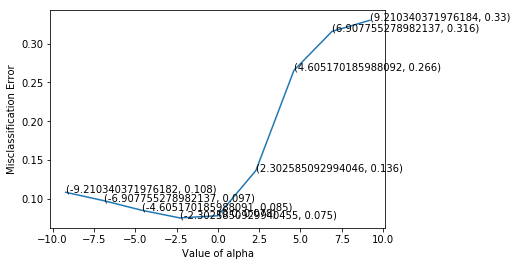

the misclassification error for each k value is :  [0.108 0.097 0.085 0.075 0.078 0.136 0.266 0.316 0.33 ]


Text(0,0.5,'score')

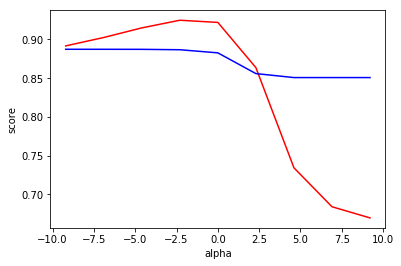

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Creating alpha values in the range from 10^-4 to 10^4
neighbors = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
# empty list that will hold cv scores
cv_scores = []
training_scores =[]
# perform 10-fold cross validation
for k in neighbors:
    nb = MultinomialNB(alpha=k)
    nb.fit(X_train_vec, Y_train)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(nb, X_test_vec, Y_test, cv=10, scoring='roc_auc')
    scores_training = nb.fit(X_train_vec, Y_train).score(X_train_vec, Y_train)
    cv_scores.append(scores.mean())
    training_scores.append(scores_training)
    #print((nb))
    
MSE = [1 - x for x in cv_scores]
#determining best k
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %.8f.' % optimal_alpha)

plt.plot(np.log(neighbors), MSE)

for xy in zip(np.log(neighbors), np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))
plt.plot(np.log(neighbors), cv_scores, 'r')
plt.plot(np.log(neighbors), training_scores, 'b')
plt.xlabel('alpha')
plt.ylabel('score')                                                        
# determining best value of alpha
#best_alpha = neighbors[cv_scores.index(max(cv_scores))]
#print('\nThe optimal value of alpha is %.3f.' % best_alpha) 

In [21]:
# ============================== Multinomial Naive Bayes with alpha = optimal_alpha ============================================
# instantiate learning model alpha = optimal_alpha
from sklearn.metrics import accuracy_score
mnb1 = MultinomialNB(alpha = optimal_alpha)

# fitting the model
mnb1.fit(X_train_vec, Y_train)

# predict the response
predictions= mnb1.predict(X_test_vec)
predictions1= mnb1.predict(X_train_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_mnb_alpha = optimal_alpha
tfidf_mnb_train_acc = max(cv_scores)*100
tfidf_mnb_test_acc = acc


The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 0.100 is 86.599788%


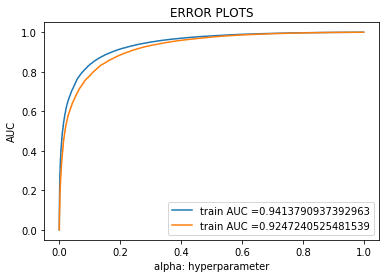

Train confusion matrix
[[ 10192  27837]
 [  1029 215861]]
Test confusion matrix
[[ 4943 14138]
 [  502 89669]]


In [22]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, mnb1.predict_proba(X_train_vec)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, mnb1.predict_proba(X_test_vec)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, mnb1.predict(X_train_vec)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, mnb1.predict(X_test_vec)))

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [23]:
# Please write all the code with proper documentation
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('like', -4.40894771917271)
('tast', -4.47930292964824)
('good', -4.614126623248737)
('flavor', -4.6357357369625625)
('love', -4.66429007687182)
('great', -4.684453739591529)
('use', -4.706008320452014)
('one', -4.762344073425835)
('product', -4.848698285348165)
('tea', -4.856661564089681)


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [24]:
# Please write all the code with proper documentation
# top 10  features
nb = MultinomialNB(alpha=optimal_alpha).fit(X_train_vec, Y_train)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= count_vect.get_feature_names()    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])



Negative top 10 important features are:
('probabl', -5.323152765579801)
('fruit', -5.333199555522202)
('diabet', -5.462993387162749)
('creativ', -5.56281606872518)
('lodg', -5.617180870847336)
('sever', -5.6207953076083825)
('matter', -5.648986574169769)
('santa', -5.663096226251608)
('outsid', -5.7395052235046435)
('cal', -5.781468980250179)


# Accuracy on test data

In [25]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\n Accuracy of the Multinomial naive Bayes of alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\n Precision of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\n Recall of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\n F1-Score of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))



 Accuracy of the Multinomial naive Bayes of alpha = 0.100 is 86.599788%

 Precision of the Multinomial naive Bayes of alpha = 0.100 is 0.863805

 Recall of the Multinomial naive Bayes of alpha = 0.100 is 0.994433

 F1-Score of the Multinomial naive Bayes of alpha = 0.100 is 0.924528


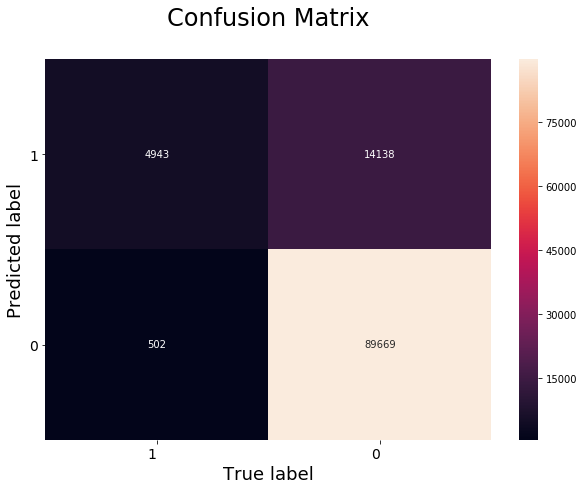

In [26]:
# Code for drawing seaborn heatmaps
class_names = [1,0]
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Accuracy On train data

In [27]:
# evaluate accuracy on train data set
acc = accuracy_score(Y_train,mnb1.predict(X_train_vec) ) * 100
print('\n Accuracy of the Multinomial naive Bayes of alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_train, mnb1.predict(X_train_vec), pos_label = 1) 
print('\n Precision of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_train, mnb1.predict(X_train_vec), pos_label = 1)
print('\n Recall of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_train, mnb1.predict(X_train_vec), pos_label = 1)
print('\n F1-Score of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))



 Accuracy of the Multinomial naive Bayes of alpha = 0.100 is 88.676403%

 Precision of the Multinomial naive Bayes of alpha = 0.100 is 0.885773

 Recall of the Multinomial naive Bayes of alpha = 0.100 is 0.995256

 F1-Score of the Multinomial naive Bayes of alpha = 0.100 is 0.937328


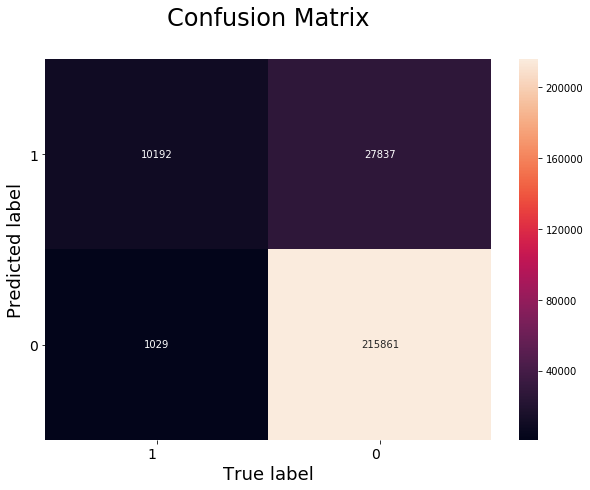

In [28]:
# Code for drawing seaborn heatmaps
#train confusion matrics
class_names = [1,0]
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, mnb1.predict(X_train_vec)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

## (a). Procedure followed :

* STEP 1 :- Text Preprocessing
* STEP 2:- Time-based splitting of whole dataset into train_data and test_data
* STEP 3:- Training the vectorizer on train_data and later applying same vectorizer on both train_data and test_data to transform them into vectors
* STEP 4:- Using Bernoulli Naive Bayes as an estimator in 10-Fold Cross-Validation in order to find optimal value of alpha .
* STEP 5:- Draw various plots auc's vs aplha,k
* STEP 6:- Once , we get optimal value of alpha then train BernoulliNB again with this optimal alpha and make predictions on test_data
* STEP 7:- Find important features per class
* STEP 8 :- Evaluate : Accuracy , F1-Score , Precision , Recall , TPR , FPR , TNR , FNR
* STEP 9:- Draw Seaborn Heatmap for Confusion Matrix .

# [6] Conclusions

In [29]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

model = ["MultinomialNB for BoW", "MultinomialNB for TFIDF"]

best_alpha = [bow_mnb_alpha, tfidf_mnb_alpha]

train_acc = [bow_mnb_train_acc, tfidf_mnb_train_acc]

test_acc = [bow_mnb_test_acc, tfidf_mnb_test_acc]

sno = [1,2]

F1_score = [0.941, 0.932]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",sno)
ptable.add_column("MODEL",model)
ptable.add_column("Best Alpha",best_alpha)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)
ptable.add_column("F1 Score",F1_score)

# Printing the Table
print(ptable)

+-------+-------------------------+------------+-------------------+-------------------+----------+
| S.NO. |          MODEL          | Best Alpha | Training Accuracy |   Test Accuracy   | F1 Score |
+-------+-------------------------+------------+-------------------+-------------------+----------+
|   1   |  MultinomialNB for BoW  |     1      | 91.76017755886518 | 89.16999231135357 |  0.941   |
|   2   | MultinomialNB for TFIDF |    0.1     | 92.48399385232894 | 86.59978764690807 |  0.932   |
+-------+-------------------------+------------+-------------------+-------------------+----------+


# feature engineering

# here i combined {cleaned text} and {summary} twice

In [30]:
conn = sqlite3.connect('featureeng.sqlite') 
final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn) 
final.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...,love book miss hard cover version
2,2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...,chicken soup rice month
3,3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...,good swingi rhythm read aloud
4,4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...,great way learn month


In [31]:
print(final['CleanedText'][0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg everi book educ everi book educ


In [32]:
from sklearn.model_selection import train_test_split
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

X = time_sorted_data['CleanedText'].values
Y = time_sorted_data['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, shuffle=False)

In [33]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(254919,) (254919,)
(109252,) (109252,)


# Naive bayes bow

In [55]:
#BoW
count_vect = CountVectorizer(min_df = 50) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (254919, 6219)
the number of unique words : 6219



The optimal value of alpha is 1.00000000.


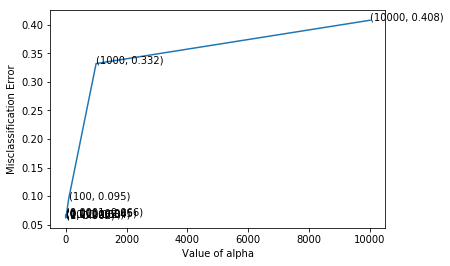

the misclassification error for each k value is :  [0.066 0.065 0.064 0.063 0.062 0.063 0.095 0.332 0.408]


Text(0,0.5,'score')

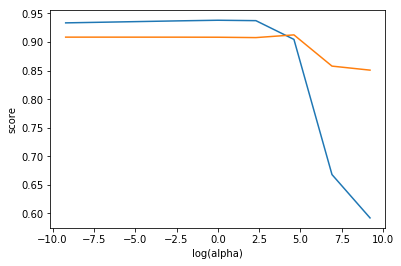

In [56]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Creating alpha values in the range from 10^-4 to 10^4
neighbors = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
# empty list that will hold cv scores
cv_scores = []
training_scores =[]
# perform 10-fold cross validation
for k in neighbors:
    nb = MultinomialNB(alpha=k)
    nb.fit(X_train_vec, Y_train)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(nb, X_test_vec, Y_test, cv=10, scoring='roc_auc')
    scores_training = nb.fit(X_train_vec, Y_train).score(X_train_vec, Y_train)
    cv_scores.append(scores.mean())
    training_scores.append(scores_training)
    #print((nb))
    
MSE = [1 - x for x in cv_scores]
#determining bst k
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %.8f.' % optimal_alpha)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))
plt.plot(np.log(neighbors), cv_scores)
plt.plot(np.log(neighbors), training_scores)
plt.xlabel('log(alpha)')
plt.ylabel('score')                                                        
# determining best value of alpha
#best_alpha = neighbors[cv_scores.index(max(cv_scores))]
#print('\nThe optimal value of alpha is %.3f.' % best_alpha) 

In [37]:
# ============================== Multinomial Naive Bayes with alpha = optimal_alpha ============================================
# instantiate learning model alpha = optimal_alpha
from sklearn.metrics import accuracy_score
mnb1 = MultinomialNB(alpha = optimal_alpha)

# fitting the model
mnb1.fit(X_train_vec, Y_train)

# predict the response
predictions= mnb1.predict(X_test_vec)
predictions1= mnb1.predict(X_train_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_mnb_alpha = optimal_alpha
bow_mnb_train_acc = max(cv_scores)*100
bow_mnb_test_acc = acc


The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 1.000 is 89.687145%


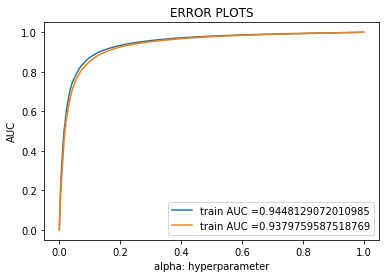

Train confusion matrix
[[ 31438   6591]
 [ 16758 200132]]
Test confusion matrix
[[15845  3236]
 [ 8031 82140]]


In [38]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, mnb1.predict_proba(X_train_vec)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, mnb1.predict_proba(X_test_vec)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, mnb1.predict(X_train_vec)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, mnb1.predict(X_test_vec)))

# top feaatures

In [39]:
# Please write all the code with proper documentation
# top 10  features
import operator
from nltk.probability import FreqDist, DictionaryProbDist, ELEProbDist, sum_logs
from nltk.classify.api import ClassifierI
from nltk.classify.naivebayes import NaiveBayesClassifier
nb = MultinomialNB(alpha=optimal_alpha).fit(X_train_vec, Y_train)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= count_vect.get_feature_names()    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    
    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])    



Negative top 10 important features are:
('tast', -4.121339830375106)
('like', -4.241897689477554)
('product', -4.420751321071874)
('flavor', -4.71711501591672)
('one', -4.7313051044323835)
('would', -4.892526612966876)
('tri', -4.896172774039712)
('good', -4.905849596162241)
('coffe', -5.005919819152609)
('use', -5.0662578511971805)
Postive top 10 important features are:
('great', -4.384114458401665)
('like', -4.436313730832627)
('tast', -4.446972529290646)
('good', -4.452495879427524)
('love', -4.547745136136161)
('flavor', -4.633749554154672)
('use', -4.758270705270817)
('tea', -4.779857906273282)
('product', -4.796793016587792)
('one', -4.8027358293294)


# Accuracy on test data

In [40]:
# evaluate accuracy
#libraries
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

acc = accuracy_score(Y_test, predictions) * 100
print('\n Accuracy of the Multinomial naive Bayes of alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\n Precision of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\n Recall of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\n F1-Score of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))



 Accuracy of the Multinomial naive Bayes of alpha = 1.000 is 89.687145%

 Precision of the Multinomial naive Bayes of alpha = 1.000 is 0.962097

 Recall of the Multinomial naive Bayes of alpha = 1.000 is 0.910936

 F1-Score of the Multinomial naive Bayes of alpha = 1.000 is 0.935818


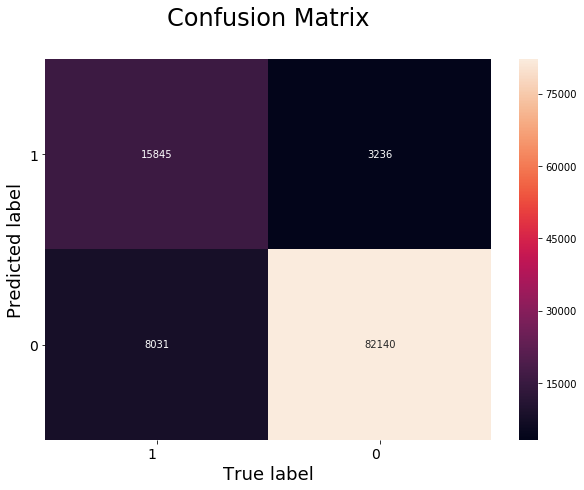

In [41]:
# Code for drawing seaborn heatmaps
#test confusion matrics
class_names = [1,0]
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Accuracy on train data

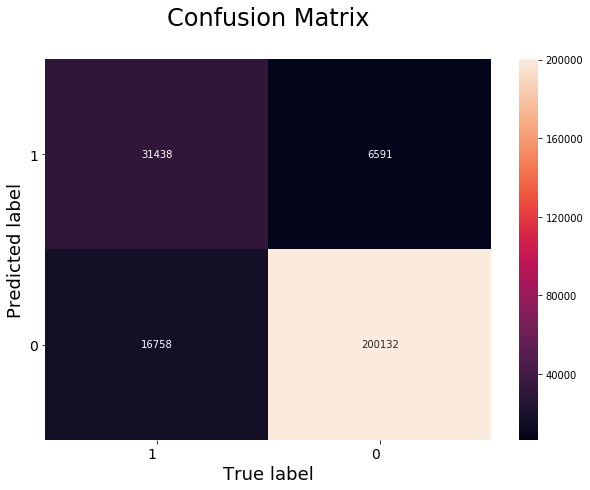

In [42]:
# Code for drawing seaborn heatmaps
#train confusion matrics
class_names = [1,0]
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, mnb1.predict(X_train_vec)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [43]:
# evaluate accuracy on train data set
acc = accuracy_score(Y_train,mnb1.predict(X_train_vec) ) * 100
print('\n Accuracy of the Multinomial naive Bayes of alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_train, mnb1.predict(X_train_vec), pos_label = 1) 
print('\n Precision of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_train, mnb1.predict(X_train_vec), pos_label = 1)
print('\n Recall of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_train, mnb1.predict(X_train_vec), pos_label = 1)
print('\n F1-Score of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))



 Accuracy of the Multinomial naive Bayes of alpha = 1.000 is 90.840620%

 Precision of the Multinomial naive Bayes of alpha = 1.000 is 0.968117

 Recall of the Multinomial naive Bayes of alpha = 1.000 is 0.922735

 F1-Score of the Multinomial naive Bayes of alpha = 1.000 is 0.944881


# on tfidf

In [44]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(min_df=10)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (254919, 13053)
the number of unique words : 13053



The optimal value of alpha is 0.10000000.


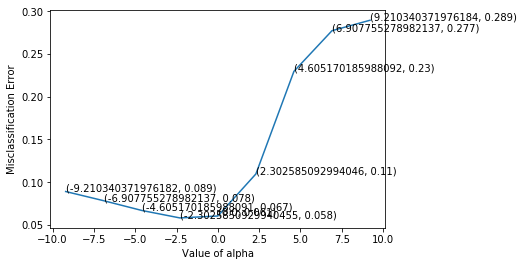

the misclassification error for each k value is :  [0.089 0.078 0.067 0.058 0.061 0.11  0.23  0.277 0.289]


Text(0,0.5,'score')

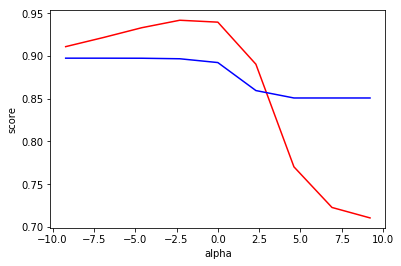

In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Creating alpha values in the range from 10^-4 to 10^4
neighbors = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
# empty list that will hold cv scores
cv_scores = []
training_scores =[]
# perform 10-fold cross validation
for k in neighbors:
    nb = MultinomialNB(alpha=k)
    nb.fit(X_train_vec, Y_train)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(nb, X_test_vec, Y_test, cv=10, scoring='roc_auc')
    scores_training = nb.fit(X_train_vec, Y_train).score(X_train_vec, Y_train)
    cv_scores.append(scores.mean())
    training_scores.append(scores_training)
    #print((nb))
    
MSE = [1 - x for x in cv_scores]
#determining best k
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %.8f.' % optimal_alpha)

plt.plot(np.log(neighbors), MSE)

for xy in zip(np.log(neighbors), np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))
plt.plot(np.log(neighbors), cv_scores, 'r')
plt.plot(np.log(neighbors), training_scores, 'b')
plt.xlabel('alpha')
plt.ylabel('score')                                                        
# determining best value of alpha
#best_alpha = neighbors[cv_scores.index(max(cv_scores))]
#print('\nThe optimal value of alpha is %.3f.' % best_alpha) 

In [47]:
# ============================== Multinomial Naive Bayes with alpha = optimal_alpha ============================================
# instantiate learning model alpha = optimal_alpha
from sklearn.metrics import accuracy_score
mnb1 = MultinomialNB(alpha = optimal_alpha)

# fitting the model
mnb1.fit(X_train_vec, Y_train)

# predict the response
predictions= mnb1.predict(X_test_vec)
predictions1= mnb1.predict(X_train_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_mnb_alpha = optimal_alpha
tfidf_mnb_train_acc = max(cv_scores)*100
tfidf_mnb_test_acc = acc


The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 0.100 is 87.818072%


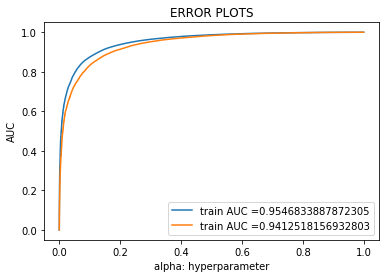

Train confusion matrix
[[ 12814  25215]
 [  1124 215766]]
Test confusion matrix
[[ 6300 12781]
 [  528 89643]]


In [48]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, mnb1.predict_proba(X_train_vec)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, mnb1.predict_proba(X_test_vec)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, mnb1.predict(X_train_vec)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, mnb1.predict(X_test_vec)))

# top features

In [49]:
# Please write all the code with proper documentation
# top 10  features
import operator
from nltk.probability import FreqDist, DictionaryProbDist, ELEProbDist, sum_logs
from nltk.classify.api import ClassifierI
from nltk.classify.naivebayes import NaiveBayesClassifier
nb = MultinomialNB(alpha=optimal_alpha).fit(X_train_vec, Y_train)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= count_vect.get_feature_names()    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    
    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])    



Negative top 10 important features are:
('procedur', -5.312587448981749)
('frys', -5.318103599134482)
('logic', -5.469848179132611)
('diamet', -5.470594991668931)
('shallow', -5.568710118651474)
('matter', -5.607535304607177)
('creativ', -5.609405435847388)
('cake', -5.653858336588055)
('satiat', -5.7055347498175975)
('outing', -5.789471974356955)
Postive top 10 important features are:
('skippi', -4.851330484981341)
('shallow', -5.0082087311264285)
('frys', -5.134762873626148)
('procedur', -5.206547838510216)
('citi', -5.394596512032123)
('satiat', -5.640891803498752)
('quit', -5.650236142479857)
('marshmallow', -5.682865187640305)
('diamet', -5.699873409450561)
('back', -5.727390200429296)


# Accuracy on test data

In [50]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\n Accuracy of the Multinomial naive Bayes of alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\n Precision of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\n Recall of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\n F1-Score of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))



 Accuracy of the Multinomial naive Bayes of alpha = 0.100 is 87.818072%

 Precision of the Multinomial naive Bayes of alpha = 0.100 is 0.875215

 Recall of the Multinomial naive Bayes of alpha = 0.100 is 0.994144

 F1-Score of the Multinomial naive Bayes of alpha = 0.100 is 0.930896


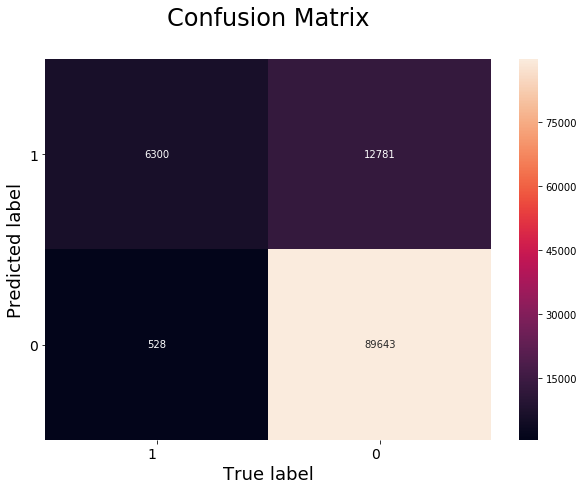

In [51]:
# Code for drawing seaborn heatmaps
class_names = [1,0]
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Accuracy on train data

In [52]:
# evaluate accuracy on train data set
acc = accuracy_score(Y_train,mnb1.predict(X_train_vec) ) * 100
print('\n Accuracy of the Multinomial naive Bayes of alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_train, mnb1.predict(X_train_vec), pos_label = 1) 
print('\n Precision of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_train, mnb1.predict(X_train_vec), pos_label = 1)
print('\n Recall of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_train, mnb1.predict(X_train_vec), pos_label = 1)
print('\n F1-Score of the Multinomial naive Bayes of alpha = %.3f is %f' % (optimal_alpha, acc))



 Accuracy of the Multinomial naive Bayes of alpha = 0.100 is 89.667698%

 Precision of the Multinomial naive Bayes of alpha = 0.100 is 0.895365

 Recall of the Multinomial naive Bayes of alpha = 0.100 is 0.994818

 F1-Score of the Multinomial naive Bayes of alpha = 0.100 is 0.942475


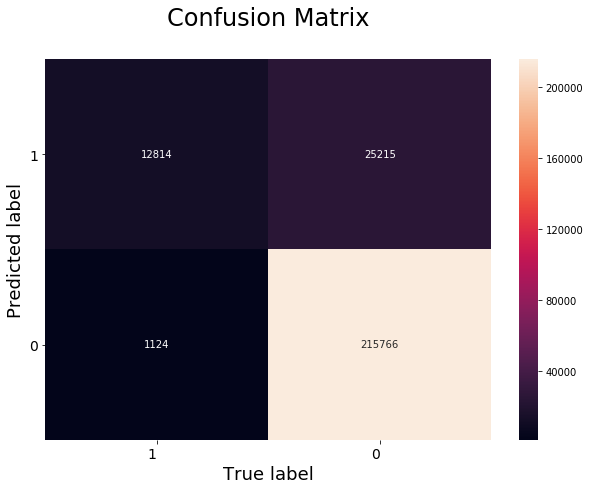

In [53]:
# Code for drawing seaborn heatmaps
#train confusion matrics
class_names = [1,0]
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, mnb1.predict(X_train_vec)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [54]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

model = ["MultinomialNB for BoW", "MultinomialNB for TFIDF"]

best_alpha = [bow_mnb_alpha, tfidf_mnb_alpha]

train_acc = [bow_mnb_train_acc, tfidf_mnb_train_acc]

test_acc = [bow_mnb_test_acc, tfidf_mnb_test_acc]

sno = [1,2]

F1_score = [0.941, 0.932]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",sno)
ptable.add_column("MODEL",model)
ptable.add_column("Best Alpha",best_alpha)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)
ptable.add_column("F1 Score",F1_score)

# Printing the Table
print(ptable)

+-------+-------------------------+------------+-------------------+-------------------+----------+
| S.NO. |          MODEL          | Best Alpha | Training Accuracy |   Test Accuracy   | F1 Score |
+-------+-------------------------+------------+-------------------+-------------------+----------+
|   1   |  MultinomialNB for BoW  |     1      | 93.81366874026789 | 89.68714531541757 |  0.941   |
|   2   | MultinomialNB for TFIDF |    0.1     |  94.172472790216  | 87.81807198037565 |  0.932   |
+-------+-------------------------+------------+-------------------+-------------------+----------+


# procedure followed

* STEP 1 :- Text Preprocessing(where i combined cleaned text,summary twice)
* STEP 2:- Time-based splitting of whole dataset into train_data and test_data
* STEP 3:- Training the vectorizer on train_data and later applying same vectorizer on both train_data and test_data to transform them into vectors
* STEP 4:- Using Bernoulli Naive Bayes as an estimator in 10-Fold Cross-Validation in order to find optimal value of alpha .
* STEP 5:- Draw various plots auc's vs aplha,k
* STEP 6:- Once , we get optimal value of alpha then train BernoulliNB again with this optimal alpha and make predictions on test_data
* STEP 7:- Find important features per class
* STEP 8 :- Evaluate : Accuracy , F1-Score , Precision , Recall , TPR , FPR , TNR , FNR
* STEP 9:- Draw Seaborn Heatmap for Confusion Matrix .

# conclusion

* by using feature engineering our performance of the models got increased slighlty 
* observe the pretty table before and after feature engineering where accuracy got increased